In [134]:
# Libraries for interfacing with WFDB data
import wfdb
from wfdb import processing



#Classical libraries 
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import trapz
from scipy.stats import norm



# importing detrending library
import obspy
from obspy.signal import detrend


## This function its used to store the ECG data inside the original files into a Pandas Dataframe

In [16]:
def import_ecg(path, files):
    
    '''
    Return ECG and RR_intervals dataframe.
    
    Inputs:
        path: path to the data's files
        files: files name without extentions
    
    outputs:
    return:
        ECG_sig: DataFrame with EGC signal for each file in each columns
        RR_intervals: DataFrame where in each columns are stored the interbeats intervals for each files
    '''


    # DataFrames to handle all signals (RAW ECG, RR intervals, Annotations, ...)
    ECG_sig=pd.DataFrame(columns=files)

    RR_intervals = pd.DataFrame(columns=files)



    # Read ECG data from files and store them in Pandas DataFrame
    # Save fields too, for further optional analysis
    signals_dfs=[]
    rr_dfs=[]

    for file in files:
        """ sig, fields =  wfdb.rdsamp(path + file, channels=[1]) # channel 1 maps to ECG data
        signals_dfs.append(pd.DataFrame({file: sig.T[0]}))

        xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
        xqrs.detect()
        rr=processing.calc_rr(xqrs.qrs_inds, fs=fields['fs']) """

        #checking for problematic files
        #if np.sum(rr)==0:
        rr = processing.ann2rr(path+file, extension='ecg')
        rr_dfs.append(pd.DataFrame({file: rr}))

    """ ECG_sig=pd.concat(signals_dfs, ignore_index=True, axis=1)
    ECG_sig.columns=files """

    RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
    RR_intervals.columns=files
    
    """ return ECG_sig, RR_intervals """
    return RR_intervals
    

## This function find problematic files and uses the annotation files to correct them
#### fixing this after loading the data inside the dataframe is a computationally faster way since we all already have the data stored inside the .hdf file and we need only to replace the corrupted column

In [17]:
def clean_df(RR_intervals, path_to_files):
    
    RR = RR_intervals.copy()
    files = list(RR.columns)
    
    #Extracting the problematc files name
    problematic_files = list(RR.columns[RR[files].sum() == 0])
    
    #Removing from the file list the problematic ones
    files = list(RR.columns[RR[files].sum() != 0])
    
    #Removing the columns which bare no value
    RR = RR.drop(problematic_files, axis=1)
    
    #Adding the new columns to the dataframe and the files name to the list
    for file in problematic_files:
        rr = processing.ann2rr(path_to_files+file, extension='ecg')
        RR = pd.concat([RR, pd.Series(rr, name=file)], axis=1)

    new_files = files + problematic_files
    
    return RR, new_files
    

## Function to compute the detrended data and then the increments from the comulative function

In [18]:
def increments(B_df, s_list, polydegree=3):
    '''
    Inputs:
        B: Dataframe with the columns to be detrended
        s_list: List of value of s to be used to detrend B
        polydegree: Polynomial's degree used to detred the data
    
    Output:
        return : List of array containing the detrended data increments for each column of B
    
    '''
    fnames = list(B_df.columns) #columns name list
    list_DB=[]
    
    for s in s_list:
        
        Delta_B_s=[] #empy list to store the increamets for a specific s regardless of the file from which the data come from

        
        for B in B_df[fnames].values.T:
            
            B = B[~np.isnan(B)] #removing all nan values from B     
            nmax_seg=int(np.floor(B.size/(2*s))) #maximum number of possible segments with increment s over B
            
            
            if nmax_seg!= 0: #avoid useless computing power
                
                for indx in range(nmax_seg):
                    detrend.polynomial(B[indx*2*s: (indx+1)*2*s], order=polydegree, plot=False) # for each sliding segment, detrend

                # the whole B but now detrended
                #detrended=B[0:2*s*nmax_seg].copy() #only those that are possible to detrend (have at least the 2s space/segment)
                detrended=B[0:2*s*nmax_seg]
                Delta_s_B_file=np.array([detrended[i+s]-detrended[i] for i in range(2*s*nmax_seg) if i+s< len(detrended)])
                Delta_B_s.append(Delta_s_B_file/np.std(Delta_s_B_file)) #since the std of very patient i svery different from each other we need to normalize the increments and join them togheter
        list_DB.append(np.concatenate(Delta_B_s))
    
    return list_DB


## Defining gaussian and Castaing's functions to fit the data

In [19]:
def gaus(x, mu, sigma, A):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2))

In [20]:
def castaing_integral(x, lambd, sigma_0):
    def little_cast(sigma, lambd, x, sigma_0):
        return 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma/sigma_0)**2/lambd**2) / 2)
    result = quad(little_cast, 0, np.inf, args=(lambd, x, sigma_0))
    return result[0]

# scipy_integrate accepts only scalar functions, we can vectorize it this way
Castaing_integral = np.vectorize(castaing_integral)

## Setting the path to the data and the file's name in order to access them

In [21]:
path='physionet.org/files/fantasia/1.0.0/' # relative path to data files
files= np.loadtxt(path+'RECORDS', dtype='str') # name of all files (no extensions as required by wfdb functions)

## This cell is meant to run only when first importing the data

In [22]:
""" #Since we do not use anymore the XQRS algortihm, we do not have i sig file
ECG_sig, RR_intervals_original = import_ecg(path, files)
ECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig_Fantasia') 
""" 
#decoment the following line if you want to save the RR_intervals_originals
""" RR_intervals_original = import_ecg(path, files)
RR_intervals_original.to_hdf('RR_intervals_original.hdf', key='RR_intervals_original_Fantasia')  """

" RR_intervals_original = import_ecg(path, files)\nRR_intervals_original.to_hdf('RR_intervals_original.hdf', key='RR_intervals_original_Fantasia')  "

## Loading the data inside a Dataframe for easier manipulation

In [23]:
RR_intervals_original=pd.read_hdf('RR_intervals_original.hdf', key='RR_intervals_original_Fantasia')
RR_intervals_original.describe()

,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y01,f2y02,f2y03,f2y04,f2y05,f2y06,f2y07,f2y08,f2y09,f2y10
count,7169.00000,6823.000000,7228.000000,6230.000000,5730.000000,6231.000000,7150.000000,8488.000000,4925.000000,8241.000000,...,8106.000000,6574.000000,6807.000000,8603.000000,9248.000000,6851.000000,6510.000000,7378.000000,8811.000000,7114.000000
mean,252.85507,265.413015,250.891118,290.682343,271.959511,292.043813,253.034126,212.388195,367.528934,220.036403,...,218.179373,356.326285,258.330689,205.012786,189.794442,256.205226,269.420737,245.285037,204.540120,252.135367
std,12.05276,11.182137,12.759428,29.414647,10.934855,7.367699,17.318108,11.575439,32.130222,14.379416,...,16.352506,36.468262,10.376207,13.163869,15.508532,18.716047,25.762242,28.560924,37.048072,75.400443
min,167.00000,75.000000,118.000000,98.000000,186.000000,146.000000,120.000000,65.000000,148.000000,128.000000,...,100.000000,248.000000,76.000000,64.000000,60.000000,56.000000,105.000000,48.000000,1.000000,64.000000
25%,246.00000,260.000000,244.000000,275.000000,264.000000,289.000000,245.000000,206.000000,354.000000,211.000000,...,210.000000,332.000000,253.000000,198.000000,184.000000,244.000000,254.000000,230.000000,192.000000,240.000000
50%,254.00000,266.000000,251.000000,292.000000,271.000000,292.000000,254.000000,213.000000,369.000000,220.000000,...,220.000000,356.000000,259.000000,206.000000,192.000000,255.000000,269.000000,245.000000,205.000000,253.000000
75%,262.00000,271.000000,259.000000,306.000000,280.000000,296.000000,263.000000,220.000000,386.000000,230.000000,...,229.000000,381.000000,265.000000,213.000000,199.000000,269.000000,286.000000,263.000000,220.000000,264.000000
max,282.00000,383.000000,336.000000,1820.000000,318.000000,362.000000,379.000000,266.000000,447.000000,267.000000,...,300.000000,549.000000,294.000000,277.000000,500.000000,333.000000,362.000000,397.000000,408.000000,6267.000000


## Clensing the dataframe from the Nan columns

In [24]:
RR_intervals, files = clean_df(RR_intervals_original, path)

## We clean the data redefining the ones that exede the interval (mean - f x std, mean+f x std)

In [25]:
factor=3

for file in files:
    mean = RR_intervals[file].mean()
    std  = RR_intervals[file].std()

    RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean


/tmp/ipykernel_636/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean
/tmp/ipykernel_636/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean
/tmp/ipykernel_636/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

# Constructing the cumulative functions from the beats intervals

In [163]:
B=pd.DataFrame(np.cumsum(RR_intervals, axis=0))
B # columns names are correct

,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y01,f2y02,f2y03,f2y04,f2y05,f2y06,f2y07,f2y08,f2y09,f2y10
0,252.85507,265.413015,250.891118,290.682343,245.0,292.043813,219.0,212.388195,367.528934,220.036403,...,218.179373,283.0,258.330689,205.012786,1.897944e+02,256.205226,269.420737,245.285037,100.000000,248.0
1,500.85507,506.413015,501.782236,599.682343,499.0,604.043813,466.0,397.388195,735.528934,446.036403,...,464.179373,591.0,515.330689,394.012786,3.827944e+02,492.205226,513.420737,475.285037,304.540120,486.0
2,745.85507,740.413015,752.673354,909.682343,748.0,911.043813,712.0,586.388195,1105.528934,672.036403,...,697.179373,911.0,765.330689,577.012786,5.787944e+02,733.205226,732.420737,708.285037,416.540120,730.0
3,992.85507,980.413015,1003.564471,1220.682343,997.0,1222.043813,952.0,775.388195,1476.528934,891.036403,...,923.179373,1213.0,1027.330689,763.012786,7.757944e+02,971.205226,949.420737,933.285037,621.080241,893.0
4,1242.85507,1216.413015,1254.455589,1536.682343,1248.0,1529.043813,1209.0,966.388195,1843.528934,1111.036403,...,1148.179373,1511.0,1288.330689,950.012786,9.687944e+02,1213.205226,1165.420737,1172.285037,739.080241,1052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.758200e+06,NaN,NaN,NaN,NaN,NaN
9244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.758378e+06,NaN,NaN,NaN,NaN,NaN
9245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.758555e+06,NaN,NaN,NaN,NaN,NaN
9246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.758729e+06,NaN,NaN,NaN,NaN,NaN


## Defining the values for s and computing the increments

In [27]:
S=[2**i for i in range(3, 12)]
list_Delta_B= increments(B, S, polydegree=3 )

In [28]:
tab20=mpl.colormaps['tab20']
colors=tab20(range(9))

## Plotting the fitted increments using a gaussian fit

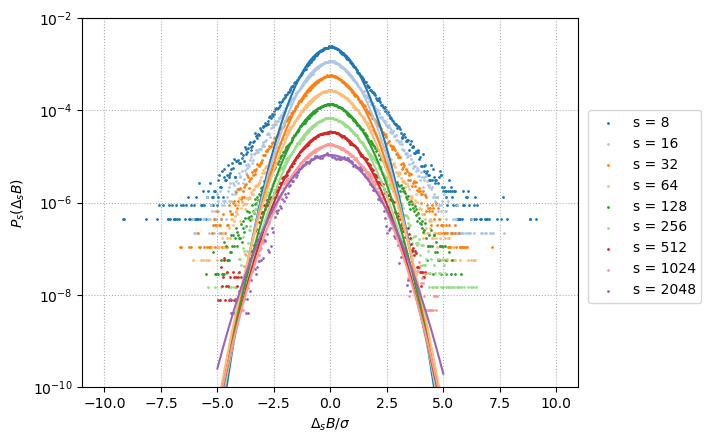

In [29]:
for i, DBs in enumerate(list_Delta_B):
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
        
    popt, pcov = curve_fit(gaus , bin_cen, counts/(S[i]*len(DBs)), p0=[1,1,1])
    
    x = np.linspace(-5, 5, 100)
    plt.plot(x, gaus(x, *popt), color=colors[i])
    
    plt.scatter(bin_cen, counts/(S[i]*len(DBs)), s=1, color=colors[i], label=f's = {S[i]}')


plt.yscale('log')
plt.ylim(1e-10, 1e-2)
plt.ylabel(r'$P_s(\Delta_s B)$')
plt.xlabel(r'$\Delta_s B/\sigma$')
plt.legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)
plt.grid(linestyle='dotted')

## Plotting the fitted data using the Castaing equation

8 (lamda, sigma0) 0.41126699376637094 0.8567551239341101
16 (lamda, sigma0) 0.40554566088173466 0.8817243814552216
32 (lamda, sigma0) 0.3729653403788642 0.9022175263040079
64 (lamda, sigma0) 0.3085773795741781 0.9279402456553604
128 (lamda, sigma0) 0.3107456857687433 0.9291412610523699
256 (lamda, sigma0) 0.28972196467706657 0.940134649370933
512 (lamda, sigma0) 0.22243316120632567 0.9625565786834722
1024 (lamda, sigma0) 0.22041977741247348 0.9874159150398266


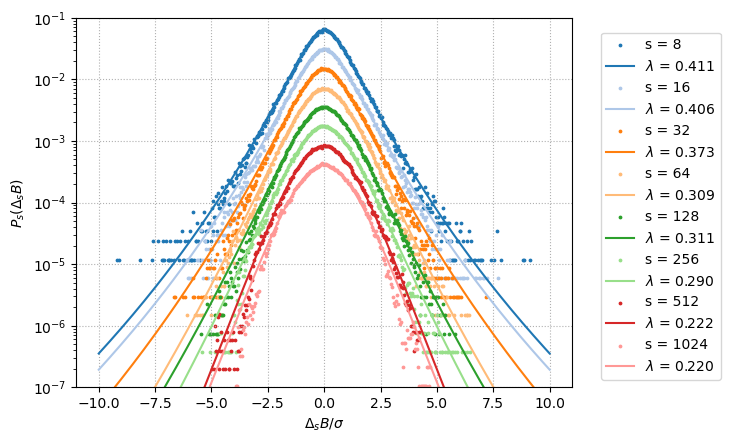

In [30]:
for i,DBs in enumerate(list_Delta_B[:-1]):
    
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
    counts=counts/np.trapz(counts, bin_cen)

    plt.scatter(bin_cen, counts/S[i], s=3, label=f's = {S[i]}', color=colors[i])
    
    popt, pcov = curve_fit(Castaing_integral, bin_cen, counts, p0=[np.sqrt(0.16), 1])
    
    
    
    x=np.linspace(-10, 10, 200)
    #plt.plot(x, Castaing_integral(x, *popt)/S[i], label='Cast {:.3f}'.format(*popt), label=f's = {S[i]}', color=colors[i])
    plt.plot(x, Castaing_integral(x, *popt)/S[i],  color=colors[i], label=r'$\lambda$ = {:.3f}'.format(*popt))
    print(S[i],'(lamda, sigma0)', *popt)


plt.legend(loc=(1,0))
#plt.xlim(-2,2)
plt.yscale('log')
#plt.ylim(10e-6, 10e1)
plt.grid(linestyle='dotted')
#plt.xlim(-1,1)
plt.ylim(1e-7, 1e-1)
plt.ylabel(r'$P_s(\Delta_s B)$')
plt.xlabel(r'$\Delta_s B/\sigma$')
plt.legend(bbox_to_anchor=(1.3, 0.96), borderaxespad=0)
plt.grid(linestyle='dotted')
plt.show()

## Generating the collapse plot from all data 

In [31]:
complete_dataset=np.concatenate(list_Delta_B)

(1499,) (1499,)
Chi squared 0.0002598349274549158
Chi squared g 0.0016419470119206742


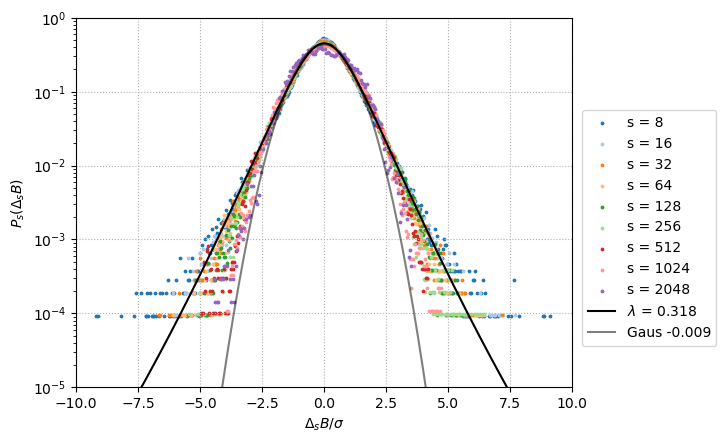

In [32]:


for i,DBs in enumerate(list_Delta_B):
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
    #print('Area before norm',np.trapz(counts, bin_cen))
    #plt.scatter(bin_cen, counts, s=3)

    #print('SONO UGUALI?',len(d), np.sum(counts))
    counts=counts/np.trapz(counts, bin_cen)

    #print('Area after norm',np.trapz(counts, bin_cen))
    plt.scatter(bin_cen, counts, s=3, label=f's = {S[i]}' , color=colors[i])

    mu, std=norm.fit(counts, fscale=1) # to imporove to properly fit data
    #print(std)
    #p = norm.pdf(x, mu, std)

    #
    #print(S[i],'lambda=', *popt)

    #for i in range(1,20):
    #plt.plot(x, Castaing_integral(x, 0.3), label='Cast '+str(0.3))

x=np.linspace(-10, 10, 200)
counts_all, edges_all=np.histogram(complete_dataset, bins=int(np.sqrt(complete_dataset.size)), range=(-10, 10))

bin_cen_all=(edges_all[1:]+edges_all[:-1])/2
counts_all=counts_all/np.trapz(counts_all, bin_cen_all)

popt, pcov = curve_fit(Castaing_integral, bin_cen_all, counts_all, p0=[np.sqrt(0.16), 1])
plt.plot(x, Castaing_integral(x, *popt), label=r'$\lambda$ = {:.3f}'.format(*popt), color='black')

popt_g, pcov_g = curve_fit(gaus, bin_cen_all, counts_all, p0=[np.sqrt(0.16), 1, 1])
plt.plot(x, gaus(x, *popt_g), label='Gaus {:.3f}'.format(*popt_g), color='black', alpha=0.5)

print(counts_all.shape, Castaing_integral(bin_cen_all, *popt).shape)
#print('Chi all',chisquare(f_obs=counts_all, f_exp=Castaing_integral(bin_cen_all, *popt), ddof=2))
chi_2=np.sum((counts_all[counts_all!=0]-Castaing_integral(bin_cen_all[counts_all!=0], *popt))**2/(counts_all[counts_all!=0]))/(counts_all[counts_all!=0].shape[0]-2)
print('Chi squared', chi_2)

chi_2_g=np.sum((counts_all[counts_all!=0]-gaus(bin_cen_all[counts_all!=0], *popt_g))**2/(counts_all[counts_all!=0]))/(counts_all[counts_all!=0].shape[0]-2)
print('Chi squared g', chi_2_g)


plt.legend(loc=(1,0))
#plt.xlim(-2,2)
plt.yscale('log')
#plt.ylim(10e-6, 10e1)
plt.grid(linestyle='dotted')
#plt.xlim(-1,1)
plt.xlim(-10,10)
plt.ylim(1e-5, 1e0)
plt.ylabel(r'$P_s(\Delta_s B)$')
plt.xlabel(r'$\Delta_s B/\sigma$')
plt.legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)
plt.show()



# Mean flactuation function 

In [220]:
 def F(B_df, s_list):
    '''
    Inputs:
        B: Dataframe with the columns to find the mean flactuation function 
        s_list: List of value of s to be used to find the mean flactuation function 
    
    Output:
        return : List of array containing the detrended data increments for each column of B
    
    '''
     #columns name list
    list_DB=[]
    
    for s in s_list:
        if type(B_df)==np.ndarray:
            B=B_df        
        else: 
            B=B_df.values   
        B = B[~np.isnan(B)] #removing all nan values from B     
        nmax_seg=int(np.floor(B.size/(2*s))) #maximum number of possible segments with increment s over B
    
        if nmax_seg!= 0: #avoid useless computing power
            Delta_s_B_file=np.array([abs(B[i+s]-B[i]) for i in range(2*s*nmax_seg) if i+s<len(B)])
        list_DB.append(Delta_s_B_file)
    
    return list_DB

In [218]:
def F_detrend(B_df, s_list, f_s=250, deg=1):
    '''
    Inputs:
        B: Dataframe with the columns to find the mean flactuation function 
        s_list: List of value of s to be used to find the mean flactuation function 
    
    Output:
        return : List of array containing the detrended data increments for each column of B
    
    '''
     #columns name list
    list_DB=[]
    
    for s in s_list:
        
        B=B_df.values.copy()
            
        B = B[~np.isnan(B)] #removing all nan values from B     
        nmax_seg=int(np.floor(B.size/(2*s))) #maximum number of possible segments with increment s over B
    
        if nmax_seg!= 0: #avoid useless computing power
            detrend.polynomial(B, order=deg, plot=False)
            detrended=B[0:2*s*nmax_seg]
            print(detrend)
            Delta_s_B_file=np.array([abs(detrend[i+s]-detrend[i]) for i in range(2*s*nmax_seg) if i+s<(2*s*nmax_seg)])
        
        list_DB.append(Delta_s_B_file)
    
    return list_DB

In [214]:
S=np.arange(200, 4000, 20, dtype=int)
a=pd.DataFrame(B.loc[:, 'f1o01'])
print(a, type(a))

           f1o01
0      252.85507
1      500.85507
2      745.85507
3      992.85507
4     1242.85507
...          ...
9243         NaN
9244         NaN
9245         NaN
9246         NaN
9247         NaN

[9248 rows x 1 columns] <class 'pandas.core.frame.DataFrame'>


# Detrending 

[1.01142028e+00 2.00342028e+00 2.98342028e+00 ... 7.25461003e+03
 7.25554603e+03 7.25652203e+03]


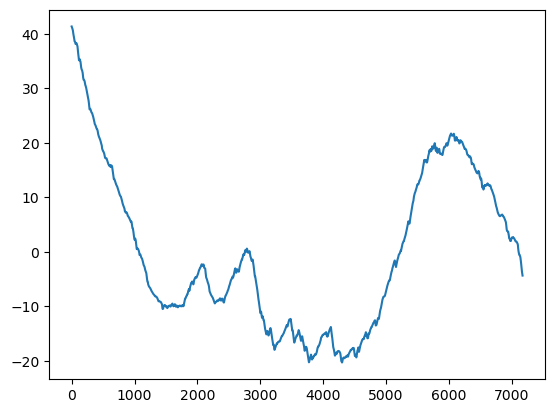

In [239]:
c = a.copy()
c = c.values/250
c = c[~np.isnan(c)]
print(c)
detrend.polynomial(c, order=1, plot=False)
index=[]
comulative=[]
for i, c_i in enumerate(c):
    index.append(i)
    comulative.append(c_i)

plt.plot(index, comulative)

In [222]:
list_F = F(c, S)
#print(np.array(list_F).shape)
#[len(f) for f in list_F]

In [147]:
df=pd.DataFrame()
for i, f in enumerate(list_F):
    df = pd.concat([df, pd.Series(np.mean(f), name=S[i])], axis=1)
df

,200,220,240,260,280,300,320,340,360,380,...,3800,3820,3840,3860,3880,3900,3920,3940,3960,3980
0,202.784092,222.978672,243.416269,263.677021,284.00456,304.438463,324.491643,344.839856,365.473369,385.437448,...,3646.680052,3646.680052,3646.680052,3646.680052,3646.680052,3646.680052,3646.680052,3646.680052,3646.680052,3646.680052


In [223]:
index=[]
mean=[]
for i, f in enumerate(list_F):
    print(len(f),'\n',  f/(S[i]), '\n')
    index.append(S[i])
    mean.append(np.mean(f)/(S[i]))

6800 
 [12.3817837  12.3717837  12.3467837  ...  5.05968229  5.01468229
  4.98968229] 

6949 
 [12.29223824 12.29223824 12.29223824 ...  8.45073632  8.53644119
  8.57669151] 

6720 
 [12.32595036 12.35095036 12.3842837  ...  7.96169919  7.94503252
  7.90753252] 

6760 
 [12.48139908 12.51216831 12.51216831 ...  5.25285954  5.21055184
  5.1720903 ] 

6720 
 [13.15392655 13.24321227 13.31821227 ...  6.67742555  6.63099698
  6.58813983] 

6600 
 [12.69011703 12.6867837  12.68345036 ...  5.5367837   5.5667837
  5.6067837 ] 

6849 
 [12.3874087  12.3655337  12.3436587  ...  8.63165693  8.68478193
  8.70040693] 

6800 
 [12.08501899 12.1085484  12.12031311 ...  5.87790051  5.9543711
  5.94303266] 

6480 
 [12.10789481 12.13011703 12.1467837  ...  5.43011703  5.39956147
  5.3467837 ] 

6789 
 [11.9467837  11.94941527 11.94415212 ...  7.33141379  7.37351906
  7.38667695] 

6400 
 [11.7567837 11.7417837 11.7167837 ...  5.6717837  5.6592837  5.6417837] 

6720 
 [11.67773608 11.69202179 11.715831

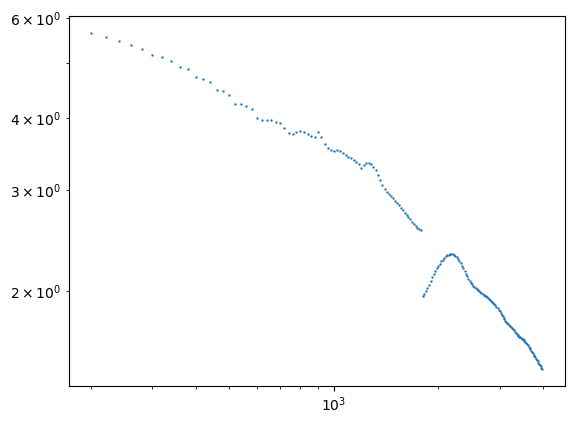

In [224]:
plt.scatter(index, mean, s=0.5)
plt.yscale('log')
plt.xscale('log')

# Frequencies filter

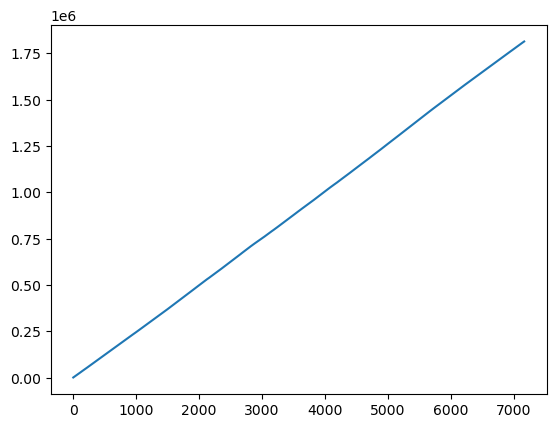

In [233]:
import scipy.fftpack as fft
c = a.copy()
c = c.values
c = c[~np.isnan(c)]

index=range(len(c))
plt.plot(index, c)

/home/vepe/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


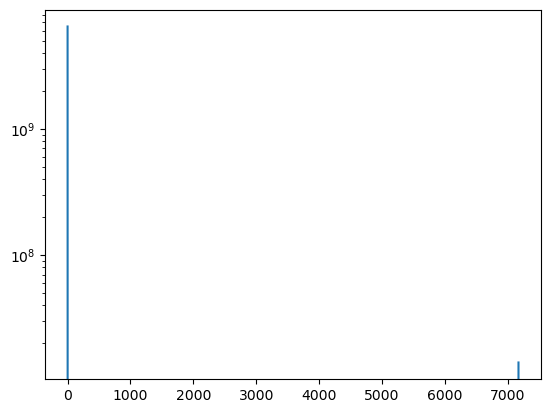

In [234]:
cf = fft.fft(c) 
plt.plot(index, cf)
plt.yscale('log')

In [237]:
cf = cf[cf<0.005]
c = fft.ifft(cf)
plt.plot(index, c)

ValueError: invalid number of data points (0) specified

# Detreanding and filtering

[1.01142028e+00 2.00342028e+00 2.98342028e+00 ... 7.25461003e+03
 7.25554603e+03 7.25652203e+03]


/home/vepe/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


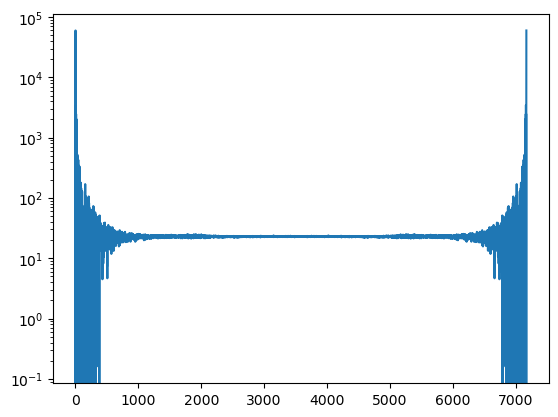

In [240]:
c = a.copy()
c = c.values/250
c = c[~np.isnan(c)]
print(c)
detrend.polynomial(c, order=1, plot=False)
index=[]
comulative=[]
for i, c_i in enumerate(c):
    index.append(i)
    comulative.append(c_i)
cf = fft.fft(comulative) 
plt.plot(index, cf)
plt.yscale('log')



ValueError: x and y must have same first dimension, but have shapes (7169,) and (223,)

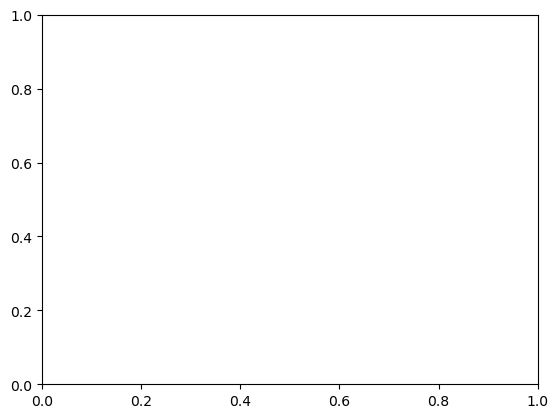

In [242]:
cf = cf[cf<0.005]
c = fft.ifft(cf)
plt.plot(index, c)

# RR invervals

In [243]:
S=np.arange(200, 4000, 20, dtype=int)
a=pd.DataFrame(RR_intervals.loc[:, 'f1o01'])
print(a, type(a))

          f1o01
0     252.85507
1     248.00000
2     245.00000
3     247.00000
4     250.00000
...         ...
9243        NaN
9244        NaN
9245        NaN
9246        NaN
9247        NaN

[9248 rows x 1 columns] <class 'pandas.core.frame.DataFrame'>


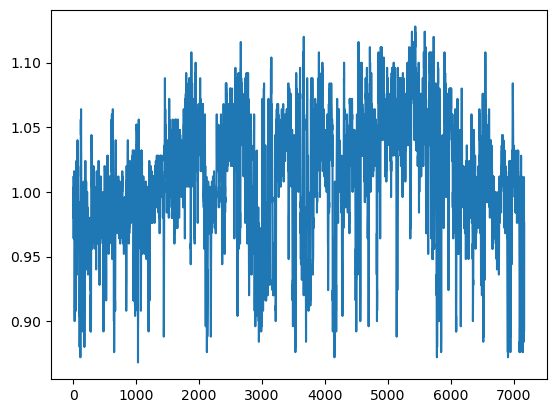

In [255]:
c = a.copy()
c = c.values
c = c[~np.isnan(c)]
index=range(len(c))
plt.plot(index, c)

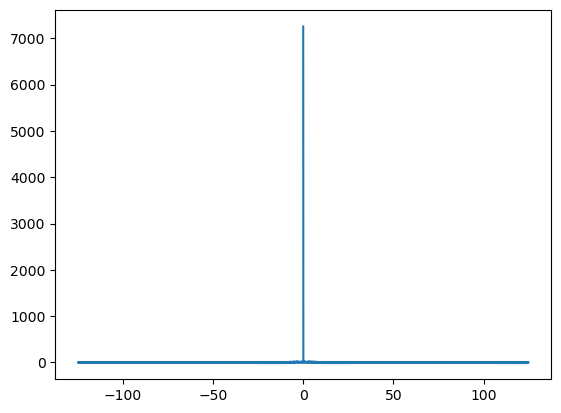

In [263]:
c_fft = fft.fft(c)
power=abs(c_fft)
sample_c = fft.fftfreq(c.size, d=1/250)

plt.plot(sample_c, power)

pos_mask = np.where(sample_c> 0)
freqs = sample_c[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]


In [265]:
high_freq_fft = c_fft.copy()
high_freq_fft[np.abs(sample_c) > peak_freq] = 0
filtered_sig = fft.ifft(high_freq_fft)

ValueError: x and y must have same first dimension, but have shapes (7169,) and (3711,)

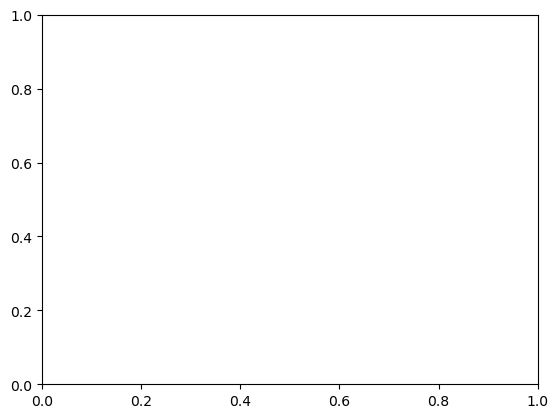

In [266]:
plt.plot(index, c)
plt.plot(index, filtered_sig)